In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

In [24]:
root_dir ="/Users/marcos/GitHubRepos/BioStatisticsDataDive/DataDive"
data_dir = root_dir+ "/data/processed/concatenated_data_csv/split_0/"

In [25]:
def get_train(data_dir, datatype):
    assert (datatype == "zscore" or datatype =="labfs" or datatype =="labfs_clipped")
    if datatype == "zscore":
        train = pd.read_csv(data_dir + "betas_train.csv")
        train_se = pd.read_csv(data_dir + "se_train.csv").iloc[:, 1:-2]
        train_betas = train.iloc[:, 1:-2]
        train_betas = train_betas.div(train_se.rename(columns={train_se.columns[i]:train_betas.columns[i] for i in range(train_betas.shape[1])}, inplace=False), axis=0)
    elif datatype == "labfs":
        train = pd.read_csv(data_dir + "labfs_train.csv")
        train_betas = train.iloc[:, 1:-2]
    elif datatype == "labfs_clipped":
        train = pd.read_csv(data_dir + "labfs_train.csv")
        train_betas = train.iloc[:, 1:-2].clip(lower=0)
    true_train_cluster_indices = train.iloc[:, -1].astype(int)
    true_train_unique_clusters = np.array(sorted(true_train_cluster_indices.unique())).flatten()
    n_classes = true_train_unique_clusters.shape[0]
    true_train_cluster_centers = np.array([train_betas[true_train_cluster_indices == c].mean(axis=0) for c in true_train_unique_clusters]).reshape(n_classes, train_betas.shape[-1])
    # Use the new colormap interface (Matplotlib ≥ 3.7)
    cmap = matplotlib.colormaps.get_cmap('tab10').resampled(n_classes)
    # Assign a unique color to each unique label
    color_dict = {label: cmap(i) for i, label in enumerate(true_train_unique_clusters)}
    colors = np.array([color_dict[label] for label in true_train_cluster_indices])
    return train_betas, true_train_cluster_indices, true_train_unique_clusters, true_train_cluster_centers, colors

def get_val(data_dir, datatype):
    assert (datatype == "zscore" or datatype =="labfs" or datatype =="labfs_clipped")
    if datatype == "zscore":
        val = pd.read_csv(data_dir + "betas_validate.csv")
        val_se = pd.read_csv(data_dir + "se_validate.csv").iloc[:, 1:-2]
        val_betas = val.iloc[:, 1:-2]
        val_betas = val_betas.div(val_se.rename(columns={val_se.columns[i]:val_betas.columns[i] for i in range(val_betas.shape[1])}, inplace=False), axis=0)
    elif datatype == "labfs":
        val = pd.read_csv(data_dir + "labfs_validate.csv")
        val_betas = val.iloc[:, 1:-2]
    elif datatype == "labfs_clipped":
        val = pd.read_csv(data_dir + "labfs_validate.csv")
        val_betas = val.iloc[:, 1:-2].clip(lower=0)
    val_cluster_indices = val.iloc[:, -1].astype(int)
    return val_betas, val_cluster_indices

def visualise_train_betas(train_betas, colors):
    for k in range(train_betas.shape[0]):
        plt.scatter(np.arange(1, train_betas.shape[1]+1), train_betas.iloc[k, :],color=colors[k], s=5)
    plt.xlabel("Variant ID")
    plt.ylabel("Regression Coefficient Against Trait")
    plt.show()
    plt.close()
    plt.scatter(np.arange(1, train_betas.shape[0]+1), train_betas.abs().sum(axis=1), s=5)
    plt.xlabel("Experiment ID")
    plt.ylabel("Mean Absolute Beta Vector")
    plt.show()
    plt.close()

def plot_aris(inc_aris):
    plt.scatter(np.arange(len(inc_aris)), inc_aris,s=10, label="Incremental")
    plt.xlabel("Number of Validation Points")
    plt.legend()
    plt.ylabel("ARI")
    plt.title(f"Final ARI After Adding All New Points Incrementally: {inc_aris[-1]}")

# Stream in the data one point at a time
def streaming_kmeans(val_betas, train_centroids, train_cluster_indices, true_train_cluster_indices, num_train_samples_per_cluster, true_val_cluster_indices, method):
    inc_clusters = []
    inc_train_centroids = train_centroids
    inc_aris = []
    for k, row in val_betas.iterrows():
        if method == "L2":
            cidx = np.argmin(np.sum(np.power(inc_train_centroids - row.to_numpy().reshape(1, -1),2), axis=-1)).item()
        elif method == "cosine":
            cidx = np.argmax((inc_train_centroids/np.linalg.norm(inc_train_centroids,ord=2, axis=1).reshape(-1,1))@((row/np.linalg.norm(row, ord=2)).to_numpy().reshape(1, -1).T).flatten()).item()
        elif method == "scaled_cosine":
            cidx = np.argmax((inc_train_centroids)@((row).to_numpy().reshape(1, -1).T).flatten()).item()
        inc_clusters.append(cidx)
        inc_aris.append(adjusted_rand_score(np.concatenate([train_cluster_indices, inc_clusters]), np.concatenate([true_train_cluster_indices, true_val_cluster_indices.iloc[:k+1]])))

        # Update the centroid
        num_train_samples_per_cluster[cidx] += 1
        inc_train_centroids[cidx, :] += (row.to_numpy()-inc_train_centroids[cidx, :]) / num_train_samples_per_cluster[cidx]

    print(np.array(inc_aris))
    return inc_aris

In [26]:
# Try initialising with the true clusters
def similarity_with_true_grounds(data_dir, true_train_cluster_centers, true_train_cluster_indices, true_train_unique_clusters, method, datatype):
    val_betas, true_val_cluster_indices = get_val(data_dir=data_dir, datatype=datatype)

    # Get cluster centroids
    train_centroids = true_train_cluster_centers
    train_cluster_indices = true_train_cluster_indices
    num_train_samples_per_cluster = {c.item(): np.sum(train_cluster_indices == c).item() for c in true_train_unique_clusters}
    train_ari = adjusted_rand_score(train_cluster_indices, true_train_cluster_indices)
    print(f"Train ARI: {train_ari}")
    inc_aris = streaming_kmeans(val_betas=val_betas, train_centroids=train_centroids, train_cluster_indices=train_cluster_indices, num_train_samples_per_cluster=num_train_samples_per_cluster, true_val_cluster_indices=true_val_cluster_indices, method=method, true_train_cluster_indices=true_train_cluster_indices)
    plot_aris(inc_aris=inc_aris)

In [27]:
datatype = "labfs"

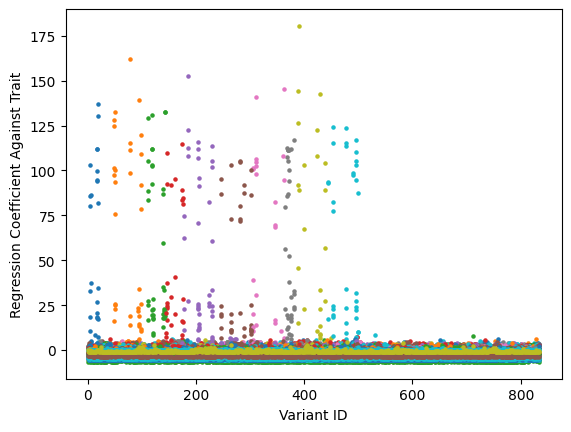

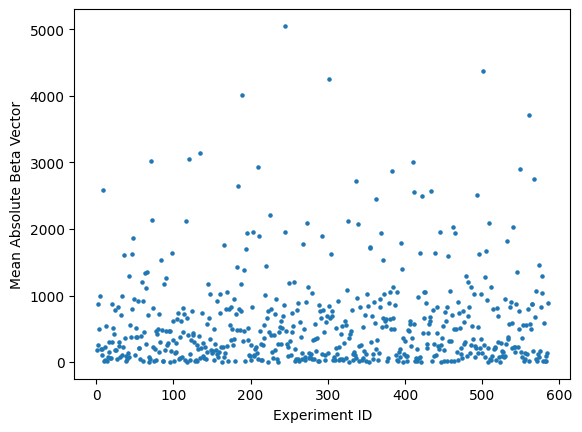

In [28]:
train_betas, true_train_cluster_indices, true_train_unique_clusters, true_train_cluster_centers, colors = get_train(data_dir=data_dir, datatype=datatype)
visualise_train_betas(train_betas=train_betas, colors=colors)

Train ARI: 1.0
[1.         1.         0.9967088  0.99343889 0.98923833 0.98544987
 0.98549371 0.98137134 0.98142708 0.97698132 0.97348997 0.97337613
 0.97346434 0.97354241 0.96884599 0.96597857 0.96607762 0.96617609
 0.9624582  0.96257971 0.96253832 0.95939591 0.95948342 0.95965529
 0.95638013 0.95634719 0.95276464 0.95238865 0.95240196 0.95258331
 0.94956812 0.94590773 0.94260431 0.94280067 0.93971378 0.93975603
 0.93979799 0.93576883 0.93600579 0.93154804 0.93179849 0.93200266
 0.93202631 0.93213812 0.93220516 0.93229358 0.93247114 0.92830621
 0.92851577 0.92485436 0.92507253 0.92518546 0.92535422 0.92250022
 0.92262156 0.92289094 0.92303393 0.92312821 0.923393   0.92343836
 0.92372389 0.92391429 0.9228162  0.9231011  0.92331432 0.92342842
 0.92342116 0.92355693 0.91886534 0.91908611 0.91916483 0.91924311
 0.91939216 0.91946929 0.91970868 0.91679879 0.91704463 0.91715148
 0.91723375 0.91727416 0.91482548 0.91514617 0.91523292 0.91214046
 0.91223492 0.90957003 0.9064442  0.9035514  0.

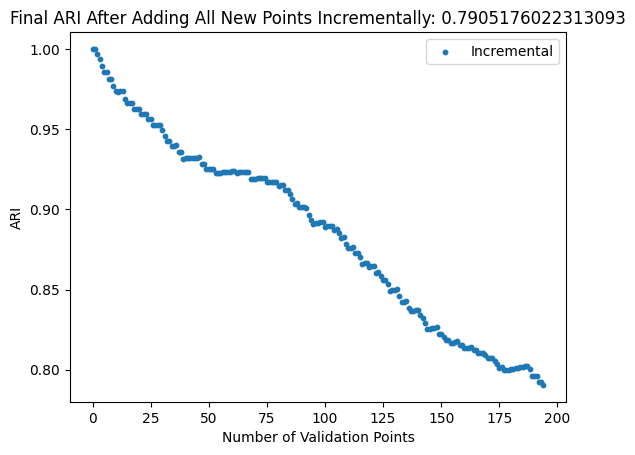

In [29]:
similarity_with_true_grounds(data_dir=data_dir,true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices, method="cosine", true_train_cluster_centers=true_train_cluster_centers, datatype=datatype)

Train ARI: 1.0
[1.         0.99631033 0.99341637 0.98996536 0.98577923 0.9829452
 0.98299664 0.98306028 0.98311103 0.97902224 0.97551796 0.97539829
 0.97547993 0.97555219 0.97174191 0.9688588  0.96894969 0.96904005
 0.96530204 0.96541462 0.96553867 0.96255343 0.96245958 0.96261924
 0.95932554 0.95928263 0.955851   0.95546368 0.95563451 0.95580404
 0.95277002 0.94908688 0.94526598 0.94527015 0.94216661 0.94203688
 0.94207082 0.93802269 0.93825188 0.93377334 0.9340162  0.93405589
 0.93407377 0.93433462 0.93439422 0.93002941 0.93021317 0.92589857
 0.92611544 0.92291467 0.92313887 0.92308368 0.92310672 0.92040448
 0.92053371 0.92081088 0.92096235 0.92091582 0.92118869 0.92124001
 0.92153424 0.92158434 0.920349   0.92064341 0.92071937 0.92098663
 0.9212758  0.92141993 0.9165898  0.9168171  0.91690244 0.9169873
 0.91728482 0.91736806 0.9176141  0.91470605 0.91495848 0.9118023
 0.91189964 0.91223401 0.90965936 0.90986512 0.90983208 0.90688762
 0.90686338 0.90407848 0.90084005 0.90088903 0.901

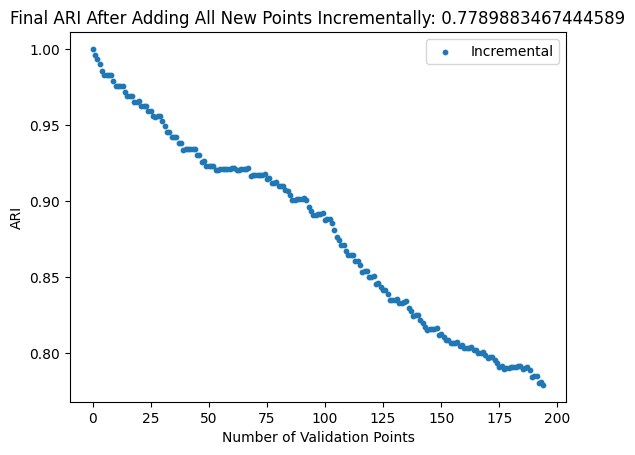

In [30]:
similarity_with_true_grounds(data_dir=data_dir,true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices, method="scaled_cosine", true_train_cluster_centers=true_train_cluster_centers, datatype=datatype)

Train ARI: 1.0
[1.         0.99708491 0.99437928 0.99111323 0.98710762 0.98351089
 0.98356065 0.97962675 0.97968781 0.97524246 0.97101936 0.96738824
 0.96749625 0.96759184 0.96293855 0.96026807 0.96038368 0.96049862
 0.95697955 0.9526156  0.95278486 0.94847438 0.94437224 0.94460709
 0.93988327 0.9399054  0.93526517 0.93196452 0.93222272 0.93247897
 0.92987398 0.92502486 0.91990639 0.91999214 0.91749104 0.9176113
 0.91788749 0.91274556 0.90735282 0.90369217 0.89825273 0.89855296
 0.89400079 0.88825556 0.88290847 0.88332042 0.88361981 0.87804378
 0.87253593 0.86699718 0.86737212 0.86196034 0.8620834  0.85653304
 0.85670483 0.85718635 0.8575738  0.85192377 0.8524145  0.85264029
 0.85316912 0.85352204 0.85097293 0.8513302  0.84568969 0.84618855
 0.84013273 0.83391306 0.82783087 0.82202891 0.81635668 0.8163686
 0.81698924 0.81733644 0.81138348 0.80584909 0.80621981 0.8002188
 0.79447001 0.79502827 0.78910373 0.78983859 0.79034763 0.78442637
 0.78483652 0.77880161 0.77714161 0.77117973 0.764

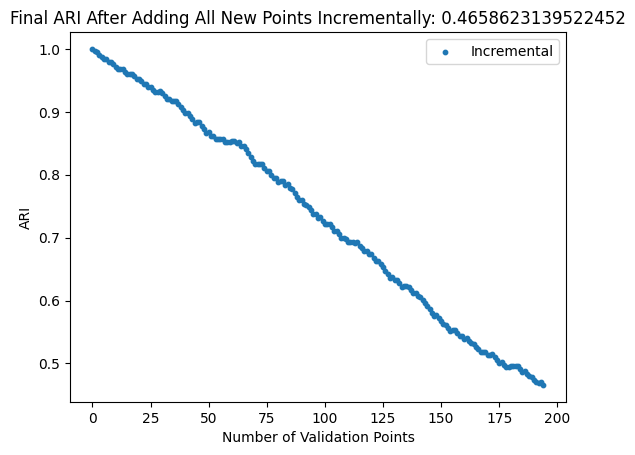

In [31]:
similarity_with_true_grounds(data_dir=data_dir,true_train_unique_clusters=true_train_unique_clusters, true_train_cluster_indices=true_train_cluster_indices, method="L2", true_train_cluster_centers=true_train_cluster_centers, datatype=datatype)